# Median + IQR SHAP Networks for NHANES I dataset XGBoost Model

This notebook implements robust aggregation using median and interquartile range (IQR) for uncertainty quantification.

**Approach:** Use median instead of mean for aggregation (robust to outliers) and compute IQR to quantify variability/uncertainty in feature importance across patients. This provides both a robust summary and uncertainty bounds.

## Robust Aggregation: IQR-Inspired Percentile-Based Uncertainty

We define a tolerance parameter γ ∈ [0, 50] based on the Interquartile Range (IQR). This parameter defines percentile bounds around the median:
- We compute the (50-γ)-th and (50+γ)-th percentiles for each agent across all patients
- When γ = 25, we obtain the classical IQR (25th and 75th percentiles)
- The parameter γ controls how strict we are about sign consistency

**Color scheme for classification:**
- **Positive (risk) nodes:** Both percentiles are positive → at least (50+γ)% of patients have a positive effect
- **Negative (protective) nodes:** Both percentiles are negative → at least (50+γ)% of patients have a negative effect
- **Gray (mixed-sign) nodes:** Percentiles have different signs → tolerance band crosses zero, indicating different effects in different patients

The same classification applies to interaction effects (edges).

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../../../../data/nhanesi/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../../../../data/nhanesi/xgboost/shap_values.npy")
shap_interaction_values = np.load("../../../../data/nhanesi/xgboost/shap_interaction_values.npy")

## Configuration: Tolerance Parameter γ

Set the tolerance parameter γ ∈ [0, 50] for percentile-based uncertainty quantification:
- γ = 25 → classical IQR (25th and 75th percentiles)
- Larger γ → stricter consistency requirements (more gray nodes)
- Smaller γ → more permissive thresholds (fewer gray nodes)

In [4]:
# Tolerance parameter for percentile-based uncertainty
gamma = 15  # Classical IQR when γ = 25

# Compute percentile bounds
lower_percentile = 50 - gamma  # e.g., 25th percentile when γ = 25
upper_percentile = 50 + gamma  # e.g., 75th percentile when γ = 25

print(f"Using γ = {gamma}")
print(f"Computing {lower_percentile}th and {upper_percentile}th percentiles")
print(f"This means at least {upper_percentile}% of patients must agree on sign for consistent classification")

Using γ = 15
Computing 35th and 65th percentiles
This means at least 65% of patients must agree on sign for consistent classification


## Build Median-Based SHAP Values (psi_1)

In [5]:
shap_values_clean = np.nan_to_num(shap_values)
n_features = shap_values_clean.shape[1]

# Calculate median SHAP values across patients
median_shap = np.median(shap_values_clean, axis=0)

# Calculate percentiles using γ parameter
# When γ = 25, this gives classical IQR (25th to 75th percentile)
q_lower_shap = np.percentile(shap_values_clean, lower_percentile, axis=0)
q_upper_shap = np.percentile(shap_values_clean, upper_percentile, axis=0)
iqr_shap = q_upper_shap - q_lower_shap

# Calculate absolute median for normalization
sum_abs_median_shap = np.sum(np.abs(median_shap))

# Build psi matrices
psi_1_median = pd.DataFrame()
psi_1_median['value'] = median_shap / sum_abs_median_shap
psi_1_median['iqr'] = iqr_shap / sum_abs_median_shap
psi_1_median[f'q25'] = q_lower_shap / sum_abs_median_shap
psi_1_median[f'q75'] = q_upper_shap / sum_abs_median_shap
psi_1_median['cv'] = iqr_shap / (np.abs(median_shap) + 1e-10)  # Coefficient of variation
psi_1_median.set_index(X_shapley.columns, inplace=True)

print(f"Median-based node weights (psi) with uncertainty (γ = {gamma}):")
print(psi_1_median.head(10))

Median-based node weights (psi) with uncertainty (γ = 15):
                                        value       iqr       q25       q75  \
sex_isFemale                        -0.116573  0.246846 -0.131446  0.115401   
age                                 -0.569398  0.797690 -0.812147 -0.014458   
physical_activity                   -0.029324  0.009091 -0.033115 -0.024023   
serum_albumin                       -0.032719  0.020484 -0.036675 -0.016191   
alkaline_phosphatase                -0.000573  0.004009 -0.002028  0.001982   
alkaline_phosphatase_isUnacceptable -0.000006  0.000003 -0.000009 -0.000006   
alkaline_phosphatase_isTestnotdone  -0.000050  0.000016 -0.000056 -0.000041   
SGOT                                -0.002691  0.003264 -0.003898 -0.000634   
SGOT_isUnacceptable                 -0.000293  0.000061 -0.000320 -0.000259   
SGOT_isTestnotdone                  -0.000036  0.000010 -0.000040 -0.000030   

                                           cv  
sex_isFemale           

## Build Median-Based Interaction Values (r_1)

In [6]:
# Remove diagonal
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(shap_interaction_values.copy())
idx_patients = np.repeat(np.arange(num_patients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_patients)
filtered_shap_interaction_values[idx_patients, idx_variables, idx_variables] = 0

# Calculate median interaction values across patients
median_interaction = np.median(filtered_shap_interaction_values, axis=0)

# Calculate percentiles using γ parameter for interactions
q_lower_interaction = np.percentile(filtered_shap_interaction_values, lower_percentile, axis=0)
q_upper_interaction = np.percentile(filtered_shap_interaction_values, upper_percentile, axis=0)
iqr_interaction = q_upper_interaction - q_lower_interaction

# Normalize
sum_abs_median_interaction = np.sum(np.abs(median_interaction))

# Build r_1 with uncertainty
r_1_median = pd.DataFrame(median_interaction / sum_abs_median_interaction)
r_1_median.rename(columns=dict(list(zip(r_1_median.columns, X_shapley.columns))), inplace=True)
r_1_median.set_index(X_shapley.columns, inplace=True)

# Store IQR separately
r_1_iqr = pd.DataFrame(iqr_interaction / sum_abs_median_interaction)
r_1_iqr.rename(columns=dict(list(zip(r_1_iqr.columns, X_shapley.columns))), inplace=True)
r_1_iqr.set_index(X_shapley.columns, inplace=True)

print(f"\nMedian-based edge weights (r) computed with γ = {gamma}")
print(f"Mean IQR for interactions: {iqr_interaction.mean():.6f}")


Median-based edge weights (r) computed with γ = 15
Mean IQR for interactions: 0.000084


In [7]:
# Store lower and upper percentiles for interactions
r_1_q_lower = pd.DataFrame(q_lower_interaction / sum_abs_median_interaction)
r_1_q_lower.rename(columns=dict(list(zip(r_1_q_lower.columns, X_shapley.columns))), inplace=True)
r_1_q_lower.set_index(X_shapley.columns, inplace=True)

r_1_q_upper = pd.DataFrame(q_upper_interaction / sum_abs_median_interaction)
r_1_q_upper.rename(columns=dict(list(zip(r_1_q_upper.columns, X_shapley.columns))), inplace=True)
r_1_q_upper.set_index(X_shapley.columns, inplace=True)

print(f"Lower ({lower_percentile}th) and upper ({upper_percentile}th) percentile dataframes created for interactions")

Lower (35th) and upper (65th) percentile dataframes created for interactions


## Normalize Matrices

In [8]:
# Create psi_1 with just the value column for normalization
psi_1 = psi_1_median[['value']].copy()
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1_median)

## Visualization

In [9]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

In [10]:
positive_color

(np.float64(0.0),
 np.float64(0.5433775692459107),
 np.float64(0.983379062301401))

Saving the graph to ..\..\..\..\result\nhanesi_xgboost_iqr_network.jpg


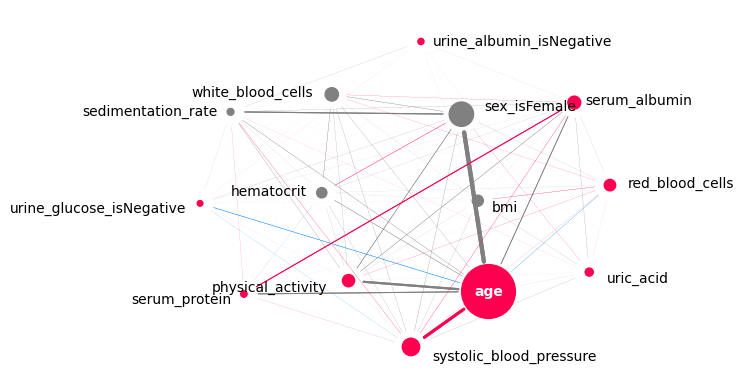

In [11]:
draw(
    psi=psi_2,
    r=r_2,
    psi_q25=psi_1_median,
    psi_q75=psi_1_median,
    r_q25=r_1_q_lower,
    r_q75=r_1_q_upper,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    uncertain_color='grey',
    output_path=os.path.join('..', '..', '..', '..', 'result', 'nhanesi_xgboost_iqr_network.jpg')
)

## Experimenting with γ

To explore different tolerance levels, modify the `gamma` parameter above and re-run the notebook:

- **γ = 10**: Very permissive (40th-60th percentiles) → fewer gray nodes, more confident classifications
- **γ = 25**: Classical IQR (25th-75th percentiles) → balanced approach
- **γ = 35**: Stricter (15th-85th percentiles) → more gray nodes, highlighting heterogeneity
- **γ = 45**: Very strict (5th-95th percentiles) → maximum gray nodes, only very consistent effects classified

The parameter γ can be adjusted according to specific requirements:
- Use **smaller γ** when you want to emphasize dominant patterns
- Use **larger γ** when you want to be conservative and highlight patient heterogeneity